In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

In [4]:
theory_difficulty_decay = -0.7
theory_stability_decay = -0.2
theory_increase_factor = 120

In [5]:
pred_difficulty_decay = -0.7
pred_stability_decay = -0.2
pred_increase_factor = 60

In [6]:
def update_stability_t(d, s, r):
    return s * (1 + theory_increase_factor * np.power(d, theory_difficulty_decay) * np.power(s, theory_stability_decay) * (np.exp(1 - r) - 1))

In [7]:
def update_stability_p(d, s, r):
    return s * (1 + pred_increase_factor * np.power(d, pred_difficulty_decay) * np.power(s, pred_stability_decay) * (np.exp(1 - r) - 1))

In [8]:
def difficulty2stability(d):
    return np.log(0.9) / np.log(0.95 + 0.005 * (10 - d))

In [9]:
def cal_stability_p_default(log: pd.DataFrame, s_old):
    ivl_list = []
    recall_list = []
    cnt_list = []
    tmp = log[log['Lapses'] == 0].copy()
    tmp['Recall'] = tmp['Grade'].map(lambda x: 0 if x == 0 else 1)
    if len(tmp) > 0:
        for ivl in set(tmp['Ivl'].values):
            r = tmp[tmp['Ivl'] == ivl]['Recall'].mean()
            if r > 0:
                ivl_list.append(ivl)
                recall_list.append(r)
                cnt_list.append(tmp[tmp['Ivl'] == ivl]['Recall'].count())
        zip_list = zip(ivl_list, recall_list, cnt_list)
        logr_ivl_cnt = sum([np.log(r) * ivl * cnt for ivl, r, cnt in zip_list])
        zip_list = zip(ivl_list, recall_list, cnt_list)
        ivl_ivl_cnt = sum(
            [ivl ** 2 * cnt for ivl, _, cnt in zip_list])
        s_new = max(np.log(0.9) / (logr_ivl_cnt / ivl_ivl_cnt), 0.1)
        return (s_new + s_old) / 2
    else:
        return s_old

In [145]:
random.seed(114514)
card_per_day_limit = 100
learn_limit = 100
review_limit = 100
deck_size = 100000  # 新卡片总量
learn_days = 150
period_len = 15
request_recall = 0.9

In [146]:
D_p_default = 5
S_p_default = 2

In [147]:
new_card_per_day = np.array([0.0] * learn_days)
new_card_per_day_average_per_period = np.array([0.0] * learn_days)
workload_per_day = np.array([0.0] * learn_days)
workload_per_day_average_per_period = np.array([0.0] * learn_days)

In [148]:
feature_list = ['D_t', 'S_t', 'R_t', 'D_p', 'S_p', 'R_p', 'Ivl', 'Due', 'Last', 'Lapses', 'Reps', 'IvlHistory', 'GradeHistory']

In [149]:
card_map = {
    'D_t': 0, 'S_t': 1, 'R_t': 2, 'D_p': 3, 'S_p': 4, 'R_p': 5, 'Ivl': 6, 'Due': 7, 'Last': 8, 'Lapses': 9, 'Reps': 10, 'IvlHistory': 11, 'GradeHistory': 12
}

In [150]:
dtypes = np.dtype([
    ('D_t', int),
    ('S_t', float),
    ('R_t', float),
    ('D_p', float),
    ('S_p', float),
    ('R_p', float),
    ('Ivl', int),
    ('Due', int),
    ('Last', int),
    ('Lapses', int),
    ('Reps', int),
    ('IvlHistory', str),
    ('GradeHistory', str),
])

In [151]:
df_card = pd.DataFrame(np.full(deck_size, np.nan, dtype=dtypes), index=range(deck_size), columns=feature_list)
df_card['D_t'] = df_card['D_t'].map(lambda x: round(max(min(random.gauss(5.5, 2), 10), 1)))
df_card['S_t'] = df_card['D_t'].map(difficulty2stability)
df_card['Due'] = learn_days
df_card['Reps'] = 0
df_card['Lapses'] = 0

In [152]:
feature_list = ['Lapses', 'Ivl', 'Memorized', 'Total']
dtypes = np.dtype([
    ('Lapses', int),
    ('Ivl', int),
    ('Memorized', int),
    ('Total', int),
])

In [153]:
df_collection = pd.DataFrame(columns=feature_list)

In [154]:
df_log = pd.DataFrame(columns=['Lapses', 'Ivl', 'Grade'])
df_oLog = pd.DataFrame(columns=["interval","difficulty","stability","retrievability","lapses"])

In [155]:
total_case = 0
total_diff = 0
total_review = 0

In [156]:
for day in tqdm(range(learn_days)):
    df_card["Ivl"] = day - df_card["Last"]  # 计算所有卡片离上次复习过去了几天
    df_card["R_p"] = np.exp(np.log(0.9) * df_card["Ivl"] / df_card["S_p"])  # 计算预测可提取性

    need_review = df_card[df_card['Due'] <= day].sort_values(by='R_p')  # 筛选到期卡片，按可提取性性从小到大排序
    true_review = need_review.index[:review_limit]
    reviewed = len(true_review)
    for idx in true_review:
        D_p = df_card.iat[idx, card_map['D_p']]
        R_p = df_card.iat[idx, card_map['R_p']]
        S_p = df_card.iat[idx, card_map['S_p']]
        Ivl = df_card.iat[idx, card_map['Ivl']]
        Reps = df_card.iat[idx, card_map['Reps']]
        Lapses = df_card.iat[idx, card_map['Lapses']]
        Grade = 0
        grade_seed = random.random()
        if grade_seed < R_t:  # 记住
            if grade_seed < R_t ** 10:
                Grade = 2  # 简单
            else:
                Grade = 1  # 一般

            if Reps > 1:  # 记录可提取性实际值和预测值的误差
                total_diff += 1 - R_p
                total_case += 1

            df_card.iat[idx, card_map['D_p']] = min(max(D_p + R_p - Grade + 0.2, 1), 10)  # 更新预测难度

            df_card.iat[idx, card_map['S_p']] = update_stability_p(df_card.iat[idx, card_map['D_p']], S_p,
                                                                   R_p)  # 更新预测稳定性
            df_card.iat[idx, card_map['Reps']] += 1
        else:  # 忘记
            Grade = 0

            if Reps > 1:
                total_diff += - R_p
                total_case += 1

            df_card.iat[idx, card_map['D_p']] = min(max(D_p + R_p - Grade + 0.2, 1), 10)

            df_card.iat[idx, card_map['S_p']] = S_p_default * np.exp(-0.3 * (Lapses + 1))  # 更新预测稳定性
            df_card.iat[idx, card_map['Lapses']] = Lapses + 1
            df_card.iat[idx, card_map['Reps']] = 1

        df_card.iat[idx, card_map['GradeHistory']] += str(Grade)
        df_card.iat[idx, card_map['IvlHistory']] += f'{Ivl},'
        df_card.iat[idx, card_map['Last']] = day
        df_card.iat[idx, card_map['Due']] = day + round(df_card.iat[idx, card_map['S_p']] * np.log(
            request_recall) / np.log(0.9))

        if Reps == 1:
            df_log = pd.concat([df_log, pd.DataFrame.from_records([{'Lapses': Lapses, 'Ivl': Ivl, 'Grade': Grade}])])

    S_p_default = cal_stability_p_default(df_log, S_p_default)  # 自适应初始稳定性

    if total_case > 100:  # 自适应初始难度
        D_p_default = 1 / np.power(total_review, 0.3) * np.power(
            np.log(request_recall) / np.log(request_recall + total_diff / total_case),
            1 / pred_difficulty_decay) * 5 + (1 - 1 / np.power(total_review, 0.3)) * D_p_default
        total_diff = 0
        total_case = 0

    need_learn = df_card[(df_card['Reps'] == 0) & (df_card['Lapses'] == 0)]  # 学习新卡片
    true_learn = need_learn.index[:min(learn_limit, card_per_day_limit - len(true_review))]
    learned = len(true_learn)
    for idx in true_learn:
        df_card.iat[idx, card_map['D_p']] = D_p_default
        df_card.iat[idx, card_map['S_p']] = S_p_default
        df_card.iat[idx, card_map['Last']] = day
        df_card.iat[idx, card_map['Due']] = day + round(S_p_default * np.log(request_recall) / np.log(0.9))
        df_card.iat[idx, card_map['Reps']] = 1

    new_card_per_day[day] = learned
    workload_per_day[day] = reviewed
    total_review += reviewed

    df_oLog["interval"] = df_card["Ivl"]
    df_oLog["difficulty"] = df_card["D_p"]
    df_oLog["stability"] = df_card["S_p"]
    df_oLog["retrievability"] = df_card["R_p"]
    df_oLog["lapses"] = df_card["Lapses"]


  0%|          | 0/150 [00:00<?, ?it/s]

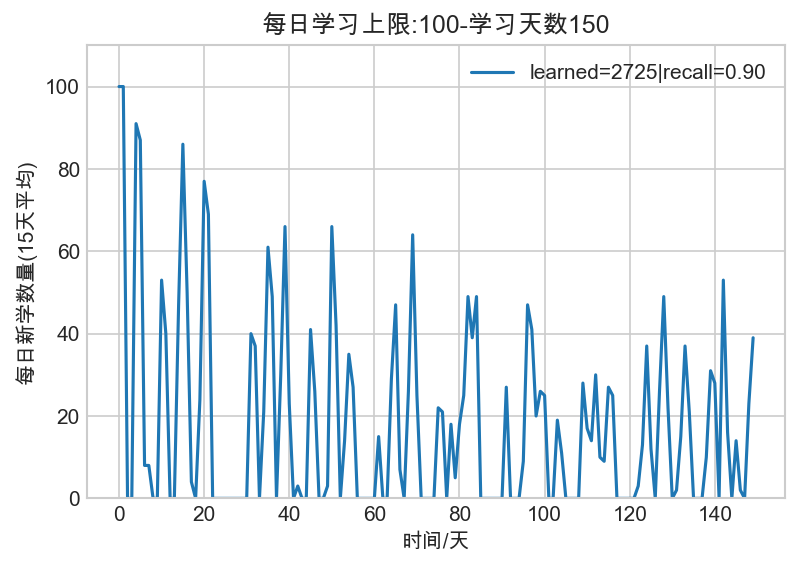

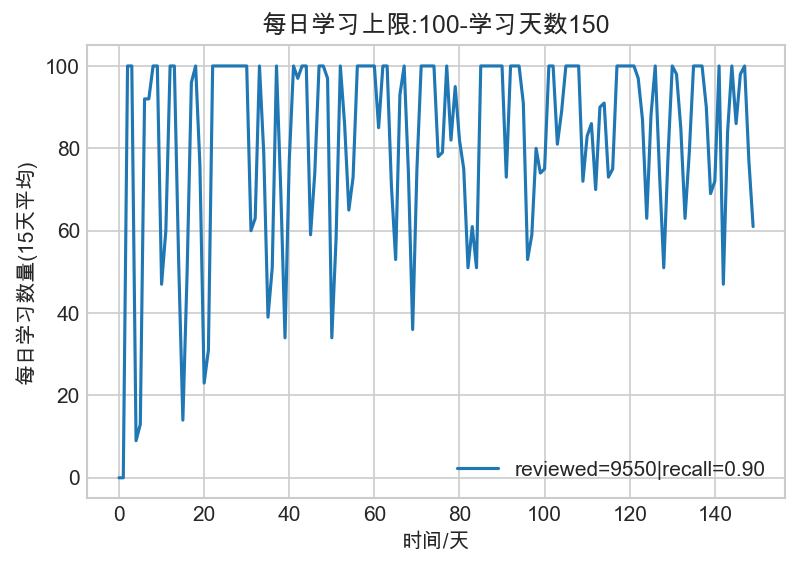

In [49]:
total_learned = int(sum(new_card_per_day))
total_reviewed = int(sum(workload_per_day)) - total_learned

plt.rcParams['figure.dpi'] = 150

plt.figure(1)
plt.plot(new_card_per_day, label=f'learned={total_learned}|recall={request_recall:.2f}')
plt.ylim((0, card_per_day_limit + 10))

plt.figure(2)
plt.plot(workload_per_day, label=f'reviewed={total_reviewed}|recall={request_recall:.2f}')

plt.figure(1)
plt.title(f"每日学习上限:{card_per_day_limit}-学习天数{learn_days}")
plt.xlabel("时间/天")
plt.ylabel(f"每日新学数量({period_len}天平均)")
plt.legend()

plt.figure(2)
plt.title(f"每日学习上限:{card_per_day_limit}-学习天数{learn_days}")
plt.xlabel("时间/天")
plt.ylabel(f"每日学习数量({period_len}天平均)")
plt.legend()
plt.show()

In [50]:
df_card

,D_t,S_t,R_t,D_p,S_p,R_p,Ivl,Due,Last,Lapses,Reps,IvlHistory,GradeHistory
0,6,3.459070,NaN,4.537288,141.008996,0.988855,15,275,134,1,6,"2,2,6,16,35,73,",021211
1,9,2.288260,NaN,3.485690,166.004245,0.991783,13,302,136,0,6,"2,6,15,34,79,",11221
2,7,2.957307,NaN,1.388811,186.823804,0.965094,63,273,86,0,5,"2,6,20,58,",2222
3,8,2.580974,NaN,2.388854,125.898186,0.941525,72,203,77,0,5,"2,6,20,49,",2212
4,5,4.161518,NaN,3.388854,109.115225,0.932839,72,186,77,0,5,"2,6,20,49,",2211
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,3,6.971221,NaN,NaN,NaN,NaN,-9223372036854775659,150,-9223372036854775808,0,0,,
99996,3,6.971221,NaN,NaN,NaN,NaN,-9223372036854775659,150,-9223372036854775808,0,0,,
99997,5,4.161518,NaN,NaN,NaN,NaN,-9223372036854775659,150,-9223372036854775808,0,0,,
99998,3,6.971221,NaN,NaN,NaN,NaN,-9223372036854775659,150,-9223372036854775808,0,0,,


In [58]:

swift_r = pd.read_csv("t.csv")

In [77]:
swift_r.dtypes

id                 object
due                object
interval            int64
difficulty        float64
stability         float64
retrievability    float64
grade              object
review             object
reps                int64
lapses              int64
dtype: object

<AxesSubplot:>

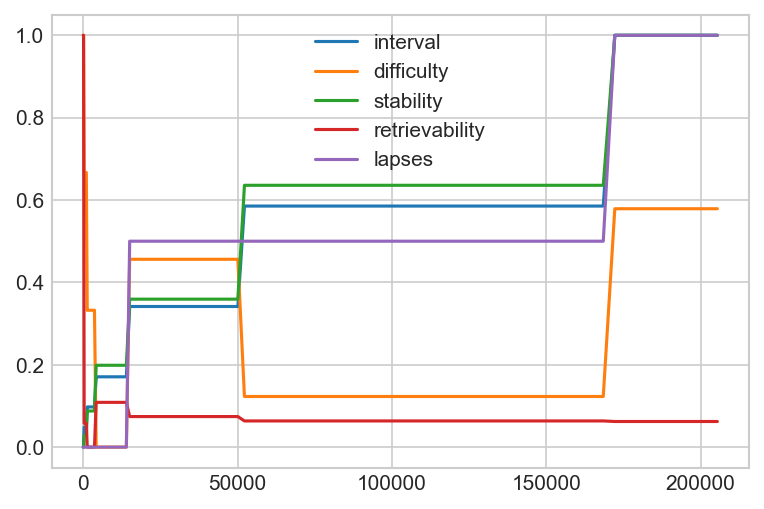

In [83]:
swift_r.groupby('id').get_group("AB8F10AC-6766-4B4A-8835-292388AB8E91")[["interval","difficulty","stability","retrievability","lapses"]].apply(lambda x: ((x-np.min(x))/(np.max(x)-np.min(x)))).plot()

In [110]:
for g in swift_r.groupby('id'):
    print(g[0], g[1].size)

0004CC43-77FE-4E56-AC0F-5F2FF0A8C749 440
0005ED41-F9D4-4536-A3C1-759BF6941996 700
000B8868-D4A6-4C12-9BE5-0FBACC476296 420
0015E0CE-8BFF-414B-B332-2255AC4241D9 70
001E761A-87DB-42A7-92FE-8D5650ECE39D 750
00272906-BC10-4563-BD03-5F786D70186E 50
00272C6C-2C43-4AD5-A298-E1AFB7509757 10
0044CC44-A688-4F59-94F5-277D5432629D 460
0047B2DC-CF54-4779-B76C-578624453C6C 480
004DF9C0-AA16-401A-BCB2-1B2512366728 490
006C2E0A-A092-4AAE-995C-C78D95BB6B15 730
009608A4-3D56-4AF1-A153-D7431311237F 420
0099C6E4-1EB0-4698-8A20-B8D6FBEECDBD 940
009F2DA1-EED6-46D2-9E99-0D934709425A 520
00B84356-8E21-47D2-8E6B-A3E371077858 690
00B9D9D2-3CBB-4E78-AF94-3697A3A72DFF 40
00C1ADDD-7BAD-4645-ACB1-618528ACCE3E 550
00CD4E80-8594-4E0B-A88E-AB0C83F6F113 720
00D6FE7D-F793-4E95-B294-97AC29F4B0E6 510
00DF0FF9-FC89-4945-A39F-EA7A2F7CB5D0 170
00F1C020-0A9E-46C7-8B0D-25D59EEE756A 700
00F2D2DD-B1C5-4727-9C44-9AC831FCAD11 140
00FA2A16-794E-4F99-B691-9C08CA676BB7 1000
00FCC31E-BF1F-4783-9A1F-0C3D823AB349 90
00FFEBF9-79DC-4155-B

In [111]:
grouped = swift_r.groupby('id')

In [127]:
A = grouped.get_group("FFD3A650-71E1-4586-B327-03AA1C2B6EE8")

In [128]:
A = A.reset_index()

<AxesSubplot:>

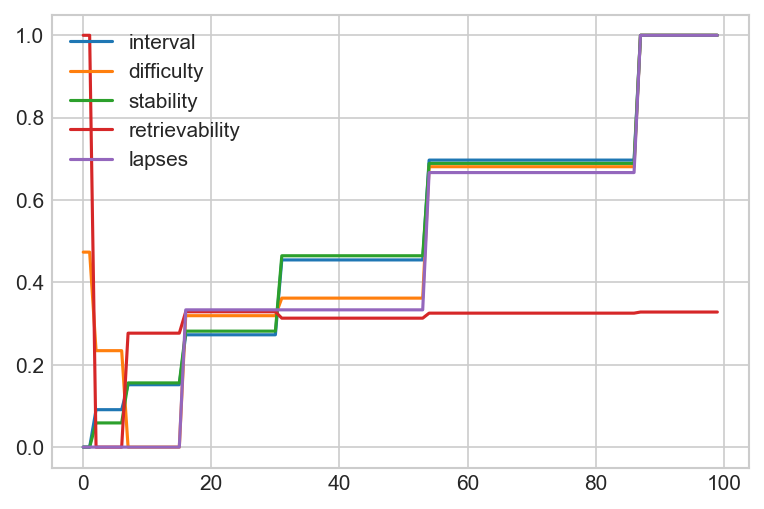

In [131]:
A[["interval","difficulty","stability","retrievability","lapses"]].apply(lambda x: ((x-np.min(x))/(np.max(x)-np.min(x)))).plot()

In [158]:
df_oLog = df_oLog[:150]

<AxesSubplot:>

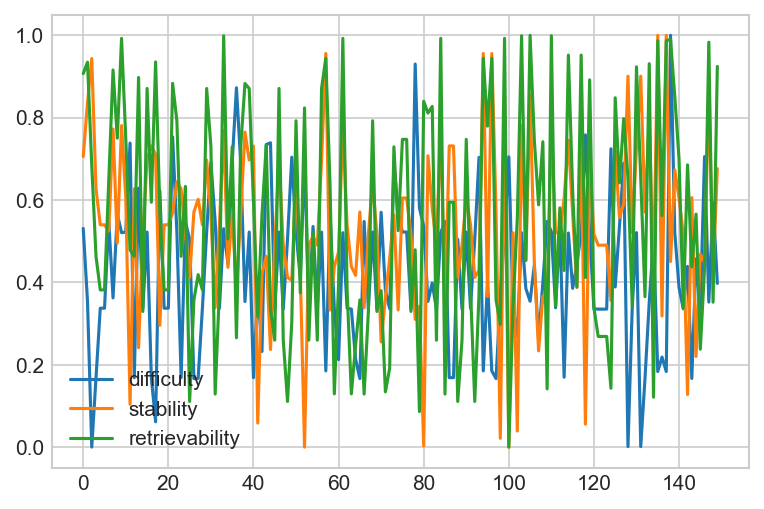

In [162]:
df_oLog[["difficulty","stability","retrievability"]].apply(lambda x: ((x-np.min(x))/(np.max(x)-np.min(x)))).plot()

<AxesSubplot:>

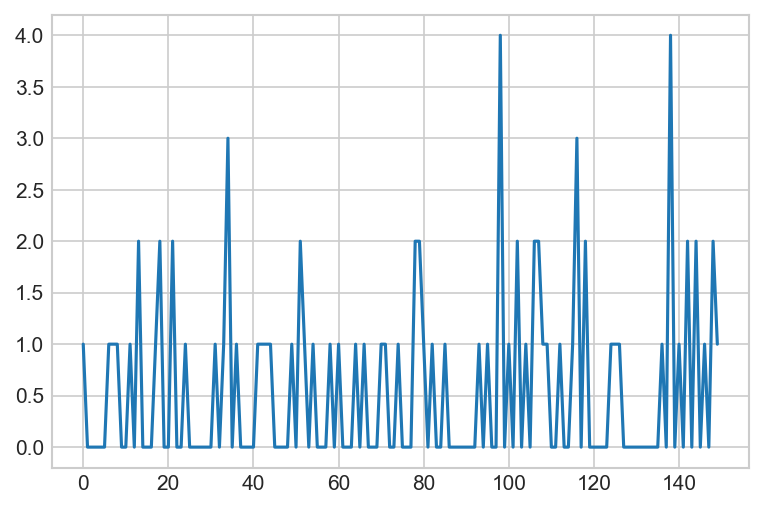

In [164]:
df_oLog["lapses"].plot()

<AxesSubplot:>

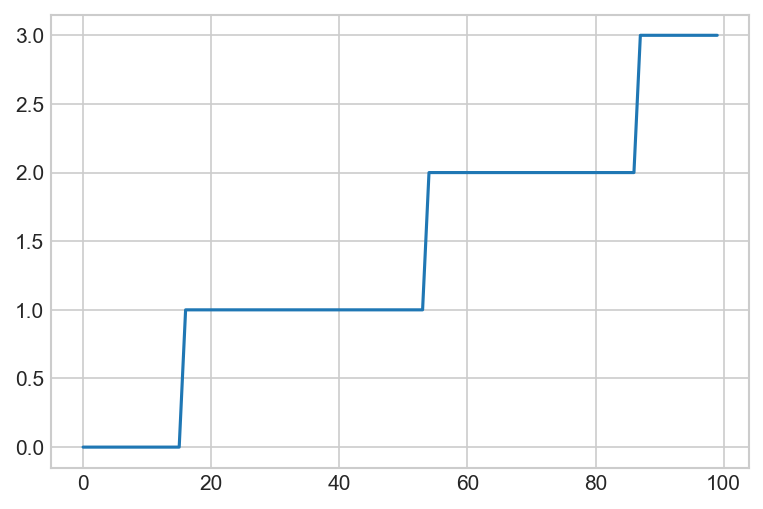

In [166]:
A["lapses"].plot()